In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

## Utils

In [3]:
def print_tree_informations(tree, training_data, testing_data):
    accuracy_testing = tree_utils.tree_accuracy(testing_data, tree)
    accuracy_training = tree_utils.tree_accuracy(training_data, tree)
    levels = tree_utils.number_of_levels(tree)
    leafs = tree_utils.number_of_leafs(tree)
    print("Accuracy for: testing {0:.2f}% | training {1:.2f}% | levels {2} | leafs {3}".format(accuracy_testing, accuracy_training,levels, leafs))

In [4]:
#heuristics
def train_and_prune_tree(heurestic, training_data, testing_data, validation_data):
    print("Before Pruning - heuristic = {0}".format(heurestic.__name__))
    trained_tree = dt_tree.build_tree_generic(heurestic, training_data)
    print_tree_informations(trained_tree, training_data, testing_data)
#     pprint(trained_tree)
    print("After Pruning:")
    pruned_trained_tree = tree_pruning.reduced_error_pruning(trained_tree, validation_data)
    print_tree_informations(pruned_trained_tree, training_data, testing_data)
    print('\n')
#     pprint(pruned_trained_tree)

In [5]:
default_heuristics = [dt_heur.gini_impurity_weighted, dt_heur.info_gain, dt_heur.information_gain_ratio,
                      dt_heur.distance_measure, dt_heur.j_measure, dt_heur.weight_of_evidence,
                      dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]
#z jakiegos powodu z tymi ktore powinny byc najwieksze nie dizala? 

# default_heuristics = [dt_heur.gini_impurity_weighted,
#                       dt_heur.gini_pri, dt_heur.relief, dt_heur.relevance, dt_heur.mdl_simple]

def train_tree_for_different_heuristics(training_data, testing_data, validation_data, heuristics = default_heuristics):
    for heuristic in heuristics:
        train_and_prune_tree(heuristic, training_data, testing_data, validation_data)

# Car dataset

## Dataset preparation

In [6]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
car_dataset.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,high,low,4,4,big,med,acc
1,med,low,5more,4,big,low,unacc
2,low,med,3,more,big,med,good
3,high,low,4,2,big,med,unacc
4,low,high,3,more,small,low,unacc


unacc    558
acc      186
vgood     31
good      30
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

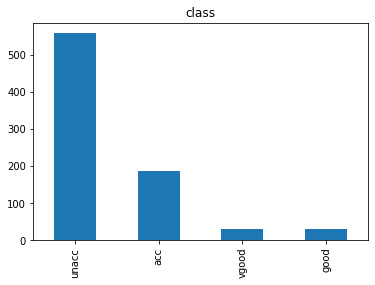

In [7]:
car_set_for_training, car_testing = data_utils.data_split(car_dataset, 70)
car_training, car_validation = data_utils.split_training_data_for_pruning(car_set_for_training)
print(car_training['CLASS'].value_counts())
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [8]:
car_training

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,high,low,4,4,big,med,acc
1,med,low,5more,4,big,low,unacc
2,low,med,3,more,big,med,good
3,high,low,4,2,big,med,unacc
4,low,high,3,more,small,low,unacc
...,...,...,...,...,...,...,...
800,low,high,5more,more,med,med,acc
801,low,vhigh,4,more,big,med,acc
802,vhigh,low,2,more,small,high,unacc
803,med,med,2,more,med,low,unacc


<AxesSubplot:title={'center':'class'}>

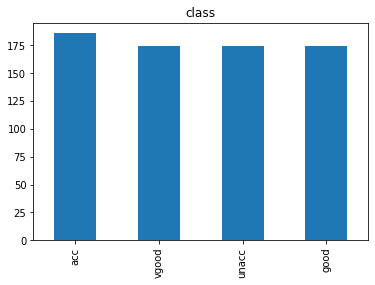

In [9]:
#Target for all 174
resampling_car = car_training.copy()
unacc_part = resampling_car[resampling_car['CLASS'] == 'unacc']
acc_part = resampling_car[resampling_car['CLASS'] == 'acc'] 
vgood_part = resampling_car[resampling_car['CLASS'] == 'vgood'] 
good_part = resampling_car[resampling_car['CLASS'] == 'good'] 


unacc_downsample = resample(unacc_part, 
                                 replace=False,     
                                 n_samples=174)

vgood_part_upsampled = resample(vgood_part, 
                                 replace=True,     
                                 n_samples=174)
good_part_upsampled = resample(good_part, 
                                 replace=True,     
                                 n_samples=174)

# Combine majority class with upsamplet minority class
balanced_car_training= pd.concat([unacc_downsample, acc_part, vgood_part_upsampled, good_part_upsampled])
balanced_car_training = balanced_car_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training = balanced_car_training.sample(frac=1).reset_index(drop=True)

car_training = balanced_car_training.copy()
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [10]:
car_training.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,low,low,2,4,big,high,vgood
1,low,low,5more,4,med,high,vgood
2,low,low,4,more,big,high,vgood
3,low,high,5more,more,med,high,vgood
4,med,high,2,more,med,med,unacc


## Model Training

In [11]:
train_tree_for_different_heuristics(car_training, car_testing, car_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 79.58% | training 95.48% | levels 10 | leafs 106
After Pruning:
Accuracy for: testing 79.38% | training 94.21% | levels 10 | leafs 100


Before Pruning - heuristic = info_gain
Accuracy for: testing 79.58% | training 95.48% | levels 10 | leafs 106
After Pruning:
Accuracy for: testing 79.38% | training 94.21% | levels 10 | leafs 100


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 84.01% | training 95.76% | levels 10 | leafs 103
After Pruning:
Accuracy for: testing 84.78% | training 94.35% | levels 10 | leafs 95


Before Pruning - heuristic = distance_measure
Accuracy for: testing 50.10% | training 80.51% | levels 10 | leafs 172
After Pruning:
Accuracy for: testing 55.30% | training 69.63% | levels 10 | leafs 111


Before Pruning - heuristic = j_measure
Accuracy for: testing 79.58% | training 95.48% | levels 10 | leafs 106
After Pruning:
Accuracy for: testing 79.38% | training 94.21% | le

# CMC Dataset

## Dataset preparation

In [12]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,20,2,3,1,1,1,2,3,0,1
1,28,1,4,0,1,0,4,1,0,1
2,47,4,4,8,1,1,1,4,0,2
3,24,2,3,2,1,1,3,1,0,1
4,35,4,4,2,0,1,3,3,0,1


1    296
3    235
2    156
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

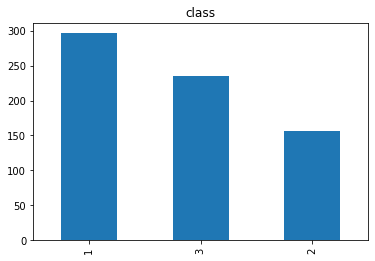

In [13]:
cmc_set_for_training, cmc_testing = data_utils.data_split(cmc_dataset, 70)
cmc_training, cmc_validation = data_utils.split_training_data_for_pruning(cmc_set_for_training)
print(cmc_training['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [14]:
train_tree_for_different_heuristics(cmc_training, cmc_testing, cmc_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 47.51% | training 80.20% | levels 32 | leafs 161
After Pruning:
Accuracy for: testing 52.71% | training 60.70% | levels 20 | leafs 31


Before Pruning - heuristic = info_gain
Accuracy for: testing 46.83% | training 61.86% | levels 60 | leafs 197
After Pruning:
Accuracy for: testing 47.74% | training 54.29% | levels 48 | leafs 134


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 46.15% | training 64.19% | levels 62 | leafs 202
After Pruning:
Accuracy for: testing 47.51% | training 55.46% | levels 48 | leafs 126


Before Pruning - heuristic = distance_measure
Accuracy for: testing 38.46% | training 52.40% | levels 40 | leafs 130
After Pruning:
Accuracy for: testing 40.27% | training 47.60% | levels 40 | leafs 52


Before Pruning - heuristic = j_measure
Accuracy for: testing 46.83% | training 61.86% | levels 60 | leafs 197
After Pruning:
Accuracy for: testing 47.74% | training 54.29% | lev

# Adult Dataset

## Data preparation

In [15]:
"""
TODO:
Drop rows with invalid values like '?'
"""
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,48,Self-emp-not-inc,317360,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,20,United-States,>50K
1,48,Private,121253,Bachelors,13,Married-spouse-absent,Sales,Unmarried,White,Female,0,2472,70,United-States,>50K
2,48,Local-gov,195949,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,42,United-States,>50K
3,70,Self-emp-not-inc,155141,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,2377,12,United-States,>50K
4,45,?,236612,11th,7,Divorced,?,Own-child,Black,Male,0,0,40,United-States,<=50K


In [16]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week','CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,CLASS
0,48,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,20,>50K
1,48,Private,Bachelors,13,Married-spouse-absent,Sales,Unmarried,White,Female,70,>50K
2,48,Local-gov,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,42,>50K
3,70,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,12,>50K
4,45,?,11th,7,Divorced,?,Own-child,Black,Male,40,<=50K


<=50K    11539
>50K      3655
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

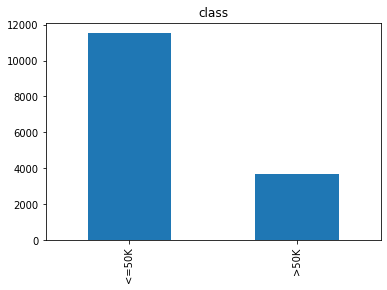

In [17]:
adult_set_for_training, adult_testing = data_utils.data_split(adult_dataset, 70)
adult_training, adult_validation = data_utils.split_training_data_for_pruning(adult_set_for_training)

print(adult_training['CLASS'].value_counts())
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

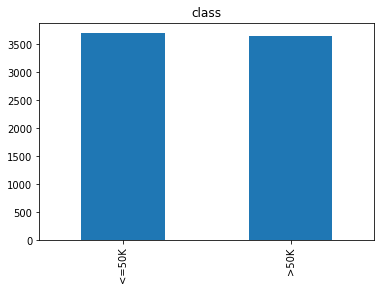

In [18]:
resampling_adult = adult_training.copy()
less_50k_part = resampling_adult[resampling_adult['CLASS'] == '<=50K']
more_50k_part = resampling_adult[resampling_adult['CLASS'] == '>50K'] 

less_50k_part_downsampled = resample(less_50k_part, 
                                 replace=False,    
                                 n_samples=3706)

# Combine minority class with downsampled majority class
balanced_adult_training = pd.concat([less_50k_part_downsampled, more_50k_part])
balanced_adult_training = balanced_adult_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training = balanced_adult_training.sample(frac=1).reset_index(drop=True)

adult_training = balanced_adult_training.copy()
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [19]:
train_tree_for_different_heuristics(adult_training, adult_testing, adult_validation)

Before Pruning - heuristic = gini_impurity_weighted
Accuracy for: testing 77.91% | training 81.84% | levels 24 | leafs 405
After Pruning:
Accuracy for: testing 79.48% | training 80.08% | levels 18 | leafs 187


Before Pruning - heuristic = info_gain
Accuracy for: testing 67.09% | training 71.73% | levels 96 | leafs 302
After Pruning:
Accuracy for: testing 75.44% | training 50.35% | levels 2 | leafs 2


Before Pruning - heuristic = information_gain_ratio
Accuracy for: testing 66.30% | training 71.16% | levels 96 | leafs 285
After Pruning:
Accuracy for: testing 75.44% | training 50.35% | levels 2 | leafs 2


Before Pruning - heuristic = distance_measure
Accuracy for: testing 70.08% | training 71.01% | levels 14 | leafs 266
After Pruning:
Accuracy for: testing 75.31% | training 59.00% | levels 14 | leafs 94


Before Pruning - heuristic = j_measure
Accuracy for: testing 67.09% | training 71.73% | levels 96 | leafs 302
After Pruning:
Accuracy for: testing 75.44% | training 50.35% | levels 2